# Diseño de un modelo para la clasificación de la pose del estudiante
En este taller vamos a desarrollar un sencillo modelo para la clasificación de la pose del estudiante con la finalidad de conocer el funcionamiento de Google Mediapipe y su aplicaciones en dispositivos edge.

In [18]:
# Dataset en dataset.zip
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import os

dataset_dir = "Student Behavior Detection.v1i.tensorflow\train"
csv_path = os.path.join(dataset_dir, "_annotations.csv")

## Dataset de estudiantes
Para el entrenamiento validacion y prueba del modelo usaremos un dataset de los estudiantes que hemos obtenido de [RoboFlow](https://universe.roboflow.com/burak-koyfx/student-behavior-detection), y lo descomprimiremos en la carpeta de nuestro Jupyter Notebook sample_data.
Los ficheros vienen prefijados con el estado del estudiante:
* forward: atento
* hand: preguntando
* read: leyendo
* around: distraido
* sleep: dormido
El dataset es bastante pequeño pero será suficiente para la finalidad del taller.

Podeis encontrar el fichero dataset.zip en la carpeta compartida.
Descomprimidlo en la carpeta `sample_data`.  


## Capturar las marcas de referencia de una pose
Para el entrenamiento del modelo, en lugar de basarnos en la imagen, lo que requeriria de un dataset bastante grande con diferentes tipos de personas, nos basaremos en el esqueleto que nos proporciona el modelo de reconocimiento de marcas de google media pipe. Estos puntos seran los que determinaran los gestos a la entrada de nuestro modelo con el fin de clasificarlo en las distintas posturas.


In [19]:
import mediapipe as mp

# Inicializar MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)
mp_drawing = mp.solutions.drawing_utils
drawing_spec = mp_drawing.DrawingSpec(thickness=2, circle_radius=2)

## Ejercicio 1: Tensores - Deteccion de marcas
En este ejercicio vamos a capturar las mascas de referencia de una pose para una imagen como un tensor.  
Cada marca de referencia cuenta con las coordenadas x,y,z y visibilidad y las devolveremos en una lista que posteriormente formará parte de un CSV.

### Landmarks Devueltos por MediaPipe Pose

MediaPipe devuelve **33 puntos o landmarks** por cada pose detectada en su modelo de detección de poses, utilizando la solución de **MediaPipe Pose**.

#### Detalles de los 33 Landmarks
Cada uno de estos puntos representa una articulación clave o una parte del cuerpo humano, como las manos, codos, hombros, rodillas, tobillos, entre otros. Los landmarks están ordenados y etiquetados, y sus posiciones están definidas en coordenadas tridimensionales: `x`, `y`, `z`.

#### Información Devuelta por Cada Landmark
Cada landmark incluye la siguiente información:

1. **Coordenadas**:
   - `x`: Coordenada horizontal, normalizada entre 0 y 1 con respecto al ancho del frame.
   - `y`: Coordenada vertical, normalizada entre 0 y 1 con respecto a la altura del frame.
   - `z`: Coordenada de profundidad relativa. Los valores negativos indican que el punto está más cerca de la cámara.
2. **Confianza**:
   - Algunos landmarks incluyen un valor de confianza que indica qué tan seguro está el modelo de la posición detectada.

#### Ejemplo de Landmarks 
A continuación, se enumeran algunos de los **33 puntos devueltos** por MediaPipe Pose:

- **Cabeza y cuello**:
  - `0`: Nariz
  - `1`: Ojo izquierdo
  - `2`: Ojo derecho
  - `3`: Oreja izquierda
  - `4`: Oreja derecha
- **Extremidades superiores**:
  - `11`: Hombro izquierdo
  - `12`: Hombro derecho
  - `13`: Codo izquierdo
  - `14`: Codo derecho
  - `15`: Muñeca izquierda
  - `16`: Muñeca derecha
- **Extremidades inferiores**:
  - `23`: Cadera izquierda
  - `24`: Cadera derecha
  - `25`: Rodilla izquierda
  - `26`: Rodilla derecha
  - `27`: Tobillo izquierdo
  - `28`: Tobillo derecho

### Uso Práctico
Cuando procesas un frame con MediaPipe, puedes acceder a estos landmarks de la siguiente manera:

```python
for landmark in results.pose_landmarks.landmark:
    print(landmark.x, landmark.y, landmark.z)


In [20]:
import cv2
import numpy as np
from typing import Optional
import matplotlib.pyplot as plt
import tensorflow as tf

def get_landmarks(image_path:str, show:bool=False) -> Optional[tf.Tensor]:
  """ Obtiene las marcas de referencia de una imagen y las devuelve en un tensor.

    Args:
      image_path(str): Ruta de la imagen.
      show(bool): Si se debe mostrar la imagen con las marcas capturadas.

    Returns:
      Optional[tf.Tensor]: Tensor con las marcas de referencia de la imagen o None si no se encontraron.
  """
  # Cargar y Procesar la imagen con MediaPipe Pose
  image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
  results = pose.process(image)

  # Extraer marcas de referencia de la pose si se detectaron
  if not results.pose_world_landmarks:
    print(f"No se encontraron puntos de referencia en la imagen '{image_path}'")
    return None
  tensor = tf.convert_to_tensor([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in results.pose_world_landmarks.landmark], dtype=tf.float32)
  if show:
    annotated_image = image.copy()
    mp_drawing.draw_landmarks(
        image=annotated_image,
        landmark_list=results.pose_landmarks,
        connections=mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=drawing_spec,
        connection_drawing_spec=drawing_spec)
    plt.imshow(annotated_image)
  return tensor

### Obteniendo el tensor de una pose

tf.Tensor(
[[ 9.74053219e-02 -5.58939934e-01 -2.57468730e-01  9.99110758e-01]
 [ 8.91458094e-02 -5.97659230e-01 -2.37186030e-01  9.98587847e-01]
 [ 8.95196274e-02 -5.98075390e-01 -2.36322239e-01  9.98634398e-01]
 [ 8.92869309e-02 -5.98368943e-01 -2.37179384e-01  9.98412251e-01]
 [ 6.02077693e-02 -5.89721441e-01 -2.51360536e-01  9.98582482e-01]
 [ 6.07232451e-02 -5.90345502e-01 -2.52580047e-01  9.98585820e-01]
 [ 6.04136474e-02 -5.91699421e-01 -2.52148867e-01  9.98476088e-01]
 [ 8.59194994e-02 -5.96241176e-01 -1.12257957e-01  9.98252213e-01]
 [-4.53772694e-02 -5.66930592e-01 -1.80553094e-01  9.99127328e-01]
 [ 1.05427064e-01 -5.38678467e-01 -2.13226706e-01  9.99189079e-01]
 [ 6.62695989e-02 -5.28218865e-01 -2.30975404e-01  9.99246597e-01]
 [ 1.58233672e-01 -4.75430250e-01  1.96085330e-02  9.99371827e-01]
 [-9.74467024e-02 -3.74876231e-01 -2.07478464e-01  9.96378243e-01]
 [ 2.93406188e-01 -3.75970930e-01 -1.05274441e-02  9.53246355e-01]
 [-4.42420784e-03 -1.73912585e-01 -2.31939957e-01  

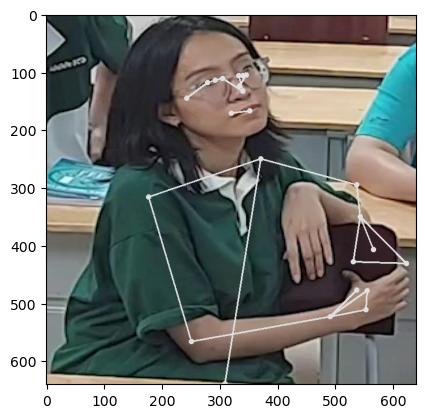

In [21]:
# image_path = "./sample_data/valid/images/around01_rgb_1_frame13_png.rf.ce99ebeb42159e3e6c0a674d10ab8d99.jpg"
image_path = r"Student Behavior Detection.v1i.tensorflow\train\around01_rgb_1_frame1_png.rf.859fb770bcf8bd3a217c2f2476545490.jpg"
pose_tensor = get_landmarks(image_path, True)
print(pose_tensor)

### Ejercicio 2 - Adjuntar los metadatos a las marcas capturadas
Para poder etiquetar los datos de entrenamiento y poder validarlos adjuntaremos los metadatos (nombre del fichero, categoria ingles, categoria español) a las marcas capturadas.

In [ ]:
# Mapeado de categorias por prefijo de la imagen
categories = {"forward":"atento", "hand":"preguntando", "read":"leyendo", "around":"distraido", "sleep":"dormido"}

def get_metadata(image_path: str) -> Optional[np.array]:
  """Extrae los metadatos del nombre del fichero y los devuelve en un numpy array:
     | nombre fichero | categoria | categoria mapeada|

    Args:
      image_path(str): Ruta de la imagen.

    Returns:
      Optional[np.array]: Numpy array con los metadatos de la imagen o None si no se encontraron.
     """
  # Para solucionar el error de las barras, comenté la linea de abajo utilizando os
  # filename = image_path.split('/')[-1]
  filename = os.path.basename(image_path)
  category = filename.split('_')[0][:-2]
  if not category in categories:
    print(f"No se encontro la categoria '{category}' para la imagen '{image_path}'")
    return None
  mapped_category = categories.get(category, category)
  return np.array([filename, category, mapped_category])

In [28]:
get_metadata(image_path)

array(['around01_rgb_1_frame1_png.rf.859fb770bcf8bd3a217c2f2476545490.jpg',
       'around', 'distraido'], dtype='<U65')

In [29]:
metadata_and_pose_data = np.hstack([get_metadata(image_path), pose_tensor.numpy().flatten()])
print(metadata_and_pose_data)

['around01_rgb_1_frame1_png.rf.859fb770bcf8bd3a217c2f2476545490.jpg'
 'around' 'distraido' '0.09740532' '-0.55893993' '-0.25746873'
 '0.99911076' '0.08914581' '-0.59765923' '-0.23718603' '0.99858785'
 '0.08951963' '-0.5980754' '-0.23632224' '0.9986344' '0.08928693'
 '-0.59836894' '-0.23717938' '0.99841225' '0.06020777' '-0.58972144'
 '-0.25136054' '0.9985825' '0.060723245' '-0.5903455' '-0.25258005'
 '0.9985858' '0.060413647' '-0.5916994' '-0.25214887' '0.9984761'
 '0.0859195' '-0.5962412' '-0.11225796' '0.9982522' '-0.04537727'
 '-0.5669306' '-0.1805531' '0.9991273' '0.105427064' '-0.53867847'
 '-0.2132267' '0.9991891' '0.0662696' '-0.52821887' '-0.2309754'
 '0.9992466' '0.15823367' '-0.47543025' '0.019608533' '0.9993718'
 '-0.0974467' '-0.37487623' '-0.20747846' '0.99637824' '0.2934062'
 '-0.37597093' '-0.010527444' '0.95324636' '-0.004424208' '-0.17391258'
 '-0.23193996' '0.9937417' '0.36347672' '-0.31260732' '-0.2098956'
 '0.96356213' '0.23243918' '-0.17641144' '-0.22687508' '0.987

### Ejercicio 3 - Aplicando la captura de marcas a nuestro dataset
Capturaremos las marcas de referencia de las imagenes del dataset y los guardaremos en un numpy array con las columnas: fichero, clase, clase mapeada (atento, preguntando, leyendo,  distraído y dormido).

In [30]:
from IPython.display import HTML, display
import tensorflow as tf
import numpy as np
import os
from typing import Tuple

def show_progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Cargar las muestras en un diccionario
def load_samples(dir_name: str, show: bool = False) -> Tuple[tf.Tensor, np.array]:
  """ Devuelve una tupla con los metadatos y el tensor apilado de todas las imagenes en la ruta especificada

    Args:
      dir_name(str): Ruta de la carpeta que contiene las imagenes.
      show(bool): Si se debe mostrar las imagenes.

    Returns:
      Tuple[tf.Tensor, np.array]: Tupla con los metadatos y el tensor apilado de todas las imagenes.
  """
  samples = []
  contador_malos=0
  metadata_array = np.empty((0, 3))
  files = [filename for filename in os.listdir(dir_name) if filename.endswith('.jpg') or filename.endswith('.png')]
  num_files = len(files)
  progress = display(show_progress(0, num_files), display_id=True)
  processed_files = 0
  for filename in sorted(files):
    # Obtener las poses de la imagen usando la funcion previamente definida get_landmarks
    image_path = dir_name+'/'+filename
    landmarks = get_landmarks(image_path)
    metadata = get_metadata(image_path)
    processed_files += 1
    progress.update(show_progress(processed_files, num_files))

    # Si no se detecta pose saltar
    if landmarks is None or landmarks.numpy().size == 0 or metadata is None:
      contador_malos+=1
      continue

    # Añadir metadatos y marcas
    metadata_array = np.vstack([metadata_array, metadata])
    samples.append(landmarks)
  print('ejemplo mal cargados',contador_malos)
  return tf.stack(samples), metadata_array

In [31]:
sample_dir = "./sample_data/train/images"
X_train, metadata_train = load_samples(sample_dir)
print(X_train)
print(metadata_train)


FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: './sample_data/train/images'

In [ ]:
X_train[0],metadata_train[0]

(<tf.Tensor: shape=(33, 4), dtype=float32, numpy=
 array([[ 0.09736225, -0.56067103, -0.2786446 ,  0.99941385],
        [ 0.08331338, -0.6009106 , -0.2597081 ,  0.9990175 ],
        [ 0.08379494, -0.6011374 , -0.25904596,  0.99912053],
        [ 0.08341904, -0.60161203, -0.2597448 ,  0.9989932 ],
        [ 0.05754721, -0.5890724 , -0.2754321 ,  0.99913055],
        [ 0.05799038, -0.58966297, -0.2767115 ,  0.9992499 ],
        [ 0.05763765, -0.5908988 , -0.2765055 ,  0.99911255],
        [ 0.06784391, -0.60480106, -0.14017382,  0.9988906 ],
        [-0.05035797, -0.5578718 , -0.21541359,  0.999469  ],
        [ 0.10294062, -0.5421788 , -0.23650809,  0.99948823],
        [ 0.06752572, -0.52670753, -0.25619242,  0.99958676],
        [ 0.1502724 , -0.48380294, -0.0160293 ,  0.99926203],
        [-0.1017577 , -0.3612426 , -0.23660897,  0.9965103 ],
        [ 0.28961855, -0.38981423, -0.05461012,  0.9375255 ],
        [-0.00271065, -0.17019288, -0.264774  ,  0.99430436],
        [ 0.37509936

### Guardamos los puntos de referencia en un CSV
Nuestro dataset estará organizado en 5 ficheros (CSV), que supondrán las 5 categorias:distraido, concentrado, preguntando, leyendo y dormido.  
En cada fichero almacenaremos una fila por cada muestra siguiendo el orden descrito aquí https://ai.google.dev/edge/mediapipe/solutions/vision/pose_landmarker#pose_landmarker_model
Tened en cuenta que por cada punto tendremos x,y,z y visibilidad y como son 33 puntos por muestra tendremos un total de 132 columnas.

### Comprobar categorias
Antes de guardar los datos vamos a comprobar los datos

In [ ]:
y_train=metadata_train[:,2]

In [ ]:
y_train[0]

'distraido'

In [ ]:
X_train[0]

<tf.Tensor: shape=(33, 4), dtype=float32, numpy=
array([[ 0.09736225, -0.56067103, -0.2786446 ,  0.99941385],
       [ 0.08331338, -0.6009106 , -0.2597081 ,  0.9990175 ],
       [ 0.08379494, -0.6011374 , -0.25904596,  0.99912053],
       [ 0.08341904, -0.60161203, -0.2597448 ,  0.9989932 ],
       [ 0.05754721, -0.5890724 , -0.2754321 ,  0.99913055],
       [ 0.05799038, -0.58966297, -0.2767115 ,  0.9992499 ],
       [ 0.05763765, -0.5908988 , -0.2765055 ,  0.99911255],
       [ 0.06784391, -0.60480106, -0.14017382,  0.9988906 ],
       [-0.05035797, -0.5578718 , -0.21541359,  0.999469  ],
       [ 0.10294062, -0.5421788 , -0.23650809,  0.99948823],
       [ 0.06752572, -0.52670753, -0.25619242,  0.99958676],
       [ 0.1502724 , -0.48380294, -0.0160293 ,  0.99926203],
       [-0.1017577 , -0.3612426 , -0.23660897,  0.9965103 ],
       [ 0.28961855, -0.38981423, -0.05461012,  0.9375255 ],
       [-0.00271065, -0.17019288, -0.264774  ,  0.99430436],
       [ 0.37509936, -0.33774936, -0

In [ ]:
print(f"Numero de tensores: {X_train.shape[0]}")
filtered_samples = metadata_train[np.isin(y_train, list(categories.values()))]
print(f"Numero de tensores filtrados: {filtered_samples.shape[0]}")
print(f"Categorias esperadas: {np.unique(y_train)} Categorias filtradas: {np.unique(filtered_samples[:, 2])})")

Numero de tensores: 1441
Numero de tensores filtrados: 1441
Categorias esperadas: ['atento' 'distraido' 'dormido' 'leyendo' 'preguntando'] Categorias filtradas: ['atento' 'distraido' 'dormido' 'leyendo' 'preguntando'])


### Ejercicio 4 - Escribiendo los metadatos y tensores en un fichero

In [ ]:
print('forma de X_train',X_train.shape)
print('número de imágenes',X_train.shape[0])
print('número de puntos por imagen',X_train.shape[1])

forma de X_train (1441, 33, 4)
número de imágenes 1441
número de puntos por imagen 33


In [ ]:
import csv



num_bodies = X_train.shape[0]
num_points = X_train.shape[1]
flattened_poses = tf.reshape(X_train, (num_bodies, num_points * 4))

filename = f"./sample_data/roboflow_dataset.csv"
with open(filename, 'w',newline='') as csv_out_file:
  writer = csv.writer(csv_out_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
  writer.writerows(np.hstack([metadata_train, flattened_poses]))

### Ejercicio 5 - Leyendo del CSV y transformando a tensores
Para leer del csv los datos tendremos que hacer lo siguiente.

In [ ]:
filename = f"./sample_data/roboflow_dataset.csv"
with open(filename, 'r') as csv_in_file:
    reader = csv.reader(csv_in_file)
    data = np.array(list(reader)).astype(str)  # Convert to float
metadata_loaded = data[:, :-132]  # Adjust according to the number of metadata columns
flattened_poses = data[:, -132:].astype(float) # The last 132 columns are the flattened poses
num_bodies = flattened_poses.shape[0]
num_points = 33  # Assuming you originally had 33 body points
X_loaded = tf.convert_to_tensor(flattened_poses.reshape(num_bodies, num_points, 4), dtype=tf.float32)
print("Metadata shape:", metadata_loaded.shape)
print("Body poses shape:", X_loaded.shape)

Metadata shape: (1441, 3)
Body poses shape: (1441, 33, 4)


## Ejercicio 6 - mapeando metadatos a valores numericos y viceversa
Ahora que ya tenemos el dataset de entrada vamos a diseñar el modelo que procesará los datos para clasificarlos en las 5 categorias que tenemos previstas.
Para ello, primero tendremos que convertir las categorias a numericas creando una tabla de búsqueda.

In [ ]:
import tensorflow as tf

# Create a lookup table to map unique labels to integers
cat_values = tf.constant(list(categories.values()))
category_encoder = tf.lookup.StaticVocabularyTable(
    tf.lookup.KeyValueTensorInitializer(
        cat_values,
        tf.range(tf.size(cat_values, out_type=tf.int64), dtype=tf.int64)),
    num_oov_buckets=1  # Handle out-of-vocabulary (OOV) labels
)

def get_metadata_numbers(poses: np.array) -> np.array:
  """ Devuelve los numeros asociados a las categorias dadas en el argumento poses.

    Args:
      poses(np.array): Tensor con las categorias.

    Returns:
      np.array: Tensor con los numeros asociados a las categorias.
  """
  return category_encoder.lookup(tf.convert_to_tensor(poses, dtype=tf.string))

def get_metadata_string(prediction: int) -> str:
  """ Devuelve las categorias dadas en el argumento poses.

    Args:
      pose(int): Tensor con los numeros de las categorias.

    Returns:
      str: nombre de la categoria.
  """
  return str(tf.gather(cat_values, [prediction]).numpy()[0])

In [ ]:
y_train = get_metadata_numbers(metadata_train[:, 2])
print(y_train)
get_metadata_string(y_train.numpy()[0])

tf.Tensor([3 3 3 ... 4 4 4], shape=(1441,), dtype=int64)


"b'distraido'"

## Ejercicio 7 - Creando el modelo de clasificacion de poses

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout

# TODO: Crear modelo secuencial con:
#  * entrada para los tensores con las marcas detectadas
#  * capa para aplanar los datos
#  * capa densa con el numero de neuronas suficientes para procesar cada tensor con activacion ReLu
#  * capa de abandono para evitar el sobreajuste del 30%
#  * capa densa con la mitad de neuronas para abstraernos con activacion ReLu
#  * capa de abandono para evitar el sobreajuste
#  * capa de salida con 5 neuronas y una función de activación softmax, que se utiliza para la clasificación en las 5 categorías.

model = Sequential([
    Input(shape=(33, 4)),
    Flatten(),
    Dense(132, activation='relu'),
    Dropout(0.3),
    Dense(66, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Ejercicio 8 - Entrenando el Modelo
A continuacion deberemos entrenar el modelo con el conjunto de datos de entrenamiento y validarlo con el conjunto de datos de validación usando `model.fit`.

In [ ]:
def load_X_y(dir_name: str, show: bool = False) -> Tuple[np.array, tf.Tensor]:
  """
  Devuelve una tupla con las categorias y el tensor apilado de todas las imagenes en la ruta especificada
  Args:
    dir_name(str): Ruta de la carpeta que contiene las imagenes.
    show(bool): Si se debe mostrar las imagenes.
  Returns:
    Tuple[np.array, ts.Tensor]: Tupla con las categorias y el tensor apilado de todas las imagenes.
  """
  X, metadata = load_samples(dir_name, show)
  return X, get_metadata_numbers(metadata[:, 2])

In [ ]:
X_train, y_train = load_X_y("./sample_data/train/images")
X_val, y_val = load_X_y("./sample_data/valid/images")

No se encontraron puntos de referencia en la imagen './sample_data/train/images/around02_rgb_1_frame130_png.rf.d0153fbc46195197acad3d552dcd929d.jpg'
No se encontraron puntos de referencia en la imagen './sample_data/train/images/around02_rgb_1_frame132_png.rf.9dce9ee89b642c6c4de694b4a92da718.jpg'
No se encontraron puntos de referencia en la imagen './sample_data/train/images/around02_rgb_1_frame137_png.rf.a90372454ec40cdb38e3450e12abedbb.jpg'
No se encontraron puntos de referencia en la imagen './sample_data/train/images/around02_rgb_1_frame143_png.rf.5b5223650eac51fff16fe796b1ed4cfb.jpg'
No se encontraron puntos de referencia en la imagen './sample_data/train/images/around02_rgb_2_frame145_png.rf.bf2f50517188d82cd30c1fdc4609dc25.jpg'
No se encontraron puntos de referencia en la imagen './sample_data/train/images/around02_rgb_2_frame149_png.rf.fc3fa22c3905c3dc0d2ea9c64e5588aa.jpg'
No se encontraron puntos de referencia en la imagen './sample_data/train/images/around02_rgb_2_frame150_pn

No se encontraron puntos de referencia en la imagen './sample_data/valid/images/around02_rgb_1_frame131_png.rf.9fa5220c9dbfcb7ba7a757a8a8941167.jpg'
No se encontraron puntos de referencia en la imagen './sample_data/valid/images/around02_rgb_1_frame134_png.rf.b0d36714256050d841aec2b2cd9ab8d4.jpg'
No se encontraron puntos de referencia en la imagen './sample_data/valid/images/around02_rgb_1_frame136_png.rf.b29c1f0e2825e4f0815c78d6cd75df68.jpg'
No se encontraron puntos de referencia en la imagen './sample_data/valid/images/around02_rgb_2_frame151_png.rf.81255b5e58dd13d0759fb40759650013.jpg'
No se encontraron puntos de referencia en la imagen './sample_data/valid/images/around12_rgb_2_frame184_png.rf.46a945fd921b0df2f3b22ffe1d2f56d4.jpg'
No se encontraron puntos de referencia en la imagen './sample_data/valid/images/around12_rgb_2_frame186_png.rf.718a3ca9a803b909ad7a6de27be3a3ac.jpg'
No se encontraron puntos de referencia en la imagen './sample_data/valid/images/around16_rgb_1_frame188_pn

In [ ]:
model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3137 - loss: 1.5466 - val_accuracy: 0.7372 - val_loss: 1.0331
Epoch 2/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6022 - loss: 1.0595 - val_accuracy: 0.7883 - val_loss: 0.7455
Epoch 3/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7208 - loss: 0.8148 - val_accuracy: 0.7981 - val_loss: 0.6374
Epoch 4/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7448 - loss: 0.7176 - val_accuracy: 0.8029 - val_loss: 0.5376
Epoch 5/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7765 - loss: 0.6354 - val_accuracy: 0.8273 - val_loss: 0.4837
Epoch 6/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8129 - loss: 0.5453 - val_accuracy: 0.8613 - val_loss: 0.4412
Epoch 7/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8412 - loss: 0.5212 - val_accuracy: 0.8759 - val_loss: 0.3800
Epoch 8/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8497 - loss: 0.4388 - val_accuracy: 0.8637 - val_loss:

# Ejercicio 9 - Evaluar el Modelo
Evaluar el modelo entrenado con el dataset de pruebas con `model.evaluate`.

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train)
print(f'Pérdida: {loss}, Precisión: {accuracy}')

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9492 - loss: 0.1228
Pérdida: 0.07590128481388092, Precisión: 0.971547544002533


# Ejercicio 10 - Ejecutando predicciones sobre el modelo entrenado
Ahora vamos a ejecutar el modelo para los datos de validacion

In [ ]:
def predict(X, metadata):
  """ Devuelve una tupla con los tensores:
  * ef: nombre del fichero
  * ec: categoria esperada
  * pc: categoria predicha
  * eq: True si la categoria predicha es igual a la esperada

    Args:
      X(tf.Tensor): tensor que contiene las marcas.
      y(np.array): numpy array que contiene las categorias esperadas.

    Returns:
      Tuple[tf.Tensor, tf.Tensor, tf.Tensor, tf.Tensor]: Tupla con los tensores:
        * ef: nombre del fichero
        * ec: categoria esperada
        * pc: categoria predicha
        * eq: True si la categoria predicha es igual a la esperada

  """
  expected_categories = category_encoder.lookup(tf.convert_to_tensor(metadata[:, 2], dtype=tf.string))
  ef = metadata[:, 0]
  ec = metadata[:, 2]
  predicted_categories = model.predict(X).argmax(axis=1)
  pc = tf.gather(cat_values, predicted_categories)
  print(list(zip(ef, ec, pc)))
  return ef, ec, pc, np.array_equal(expected_categories, predicted_categories)

def verify(X, metadata):
  """
  Verifica el conjunto de datos imprimiendo el porcentaje de exito.
  En caso de haber fallos, identificar cuales fueron y mostrar las diferencias.
  """
  ef, ec, pc, eq = predict(X, metadata)
  different_indexes = np.where(ec != pc)[0]
  print(f"{(100*(len(pc)-len(different_indexes))/len(pc)):.2f}%")
  for index in different_indexes:
    print(f"Imagen: {ef[index]}, Categoria esperada: {ec[index]}, Categoria predicha: {pc[index]}")

In [ ]:
X_val, metadata_val = load_samples("./sample_data/valid/images")

No se encontraron puntos de referencia en la imagen './sample_data/valid/images/around02_rgb_1_frame131_png.rf.9fa5220c9dbfcb7ba7a757a8a8941167.jpg'
No se encontraron puntos de referencia en la imagen './sample_data/valid/images/around02_rgb_1_frame134_png.rf.b0d36714256050d841aec2b2cd9ab8d4.jpg'
No se encontraron puntos de referencia en la imagen './sample_data/valid/images/around02_rgb_1_frame136_png.rf.b29c1f0e2825e4f0815c78d6cd75df68.jpg'
No se encontraron puntos de referencia en la imagen './sample_data/valid/images/around02_rgb_2_frame151_png.rf.81255b5e58dd13d0759fb40759650013.jpg'
No se encontraron puntos de referencia en la imagen './sample_data/valid/images/around12_rgb_2_frame184_png.rf.46a945fd921b0df2f3b22ffe1d2f56d4.jpg'
No se encontraron puntos de referencia en la imagen './sample_data/valid/images/around12_rgb_2_frame186_png.rf.718a3ca9a803b909ad7a6de27be3a3ac.jpg'
No se encontraron puntos de referencia en la imagen './sample_data/valid/images/around16_rgb_1_frame188_pn

In [ ]:
verify(X_val, metadata_val)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[('around01_rgb_1_frame13_png.rf.ce99ebeb42159e3e6c0a674d10ab8d99.jpg', 'distraido', <tf.Tensor: shape=(), dtype=string, numpy=b'distraido'>), ('around01_rgb_1_frame2_png.rf.7071229c7e431b9af18cd1a4ef5d0b93.jpg', 'distraido', <tf.Tensor: shape=(), dtype=string, numpy=b'distraido'>), ('around01_rgb_1_frame9_png.rf.46aaee2a6007f672184e9050281ce17e.jpg', 'distraido', <tf.Tensor: shape=(), dtype=string, numpy=b'distraido'>), ('around02_rgb_1_frame104_png.rf.c91f5b247c8a475f05d8c66252e808b8.jpg', 'distraido', <tf.Tensor: shape=(), dtype=string, numpy=b'distraido'>), ('around02_rgb_1_frame105_png.rf.f93258755982d37b91ab11484c9f57a1.jpg', 'distraido', <tf.Tensor: shape=(), dtype=string, numpy=b'distraido'>), ('around02_rgb_1_frame113_png.rf.4a741eb6905beca682ea0da569f4c802.jpg', 'distraido', <tf.Tensor: shape=(), dtype=string, numpy=b'distraido'>), ('around02_rgb_1_frame118_png.rf.ad3aaed59b9d0e3ae33f52dec878f511.jpg', 'distraido', <tf.Tensor: shape=(),

# Ejercicio 10 - Repetir con el modelo de pruebas
Vamos a lanzar las predicciones sobre el dataset de prueba.

In [ ]:
X_test, metadata_test = load_samples("./sample_data/test/images")

No se encontraron puntos de referencia en la imagen './sample_data/test/images/around02_rgb_1_frame133_png.rf.a1d1e40193045cb2d73a508fcd2aeffb.jpg'
No se encontraron puntos de referencia en la imagen './sample_data/test/images/around02_rgb_1_frame135_png.rf.5fbfdd53694f8987c732ed7fedf2fbf0.jpg'
No se encontraron puntos de referencia en la imagen './sample_data/test/images/around02_rgb_2_frame148_png.rf.961d726e5b4c9a1a08ae22c1f6dbe97d.jpg'
No se encontraron puntos de referencia en la imagen './sample_data/test/images/around13_rgb_1_frame15_png.rf.bec9cf8151bb46c295ae6391f194aa31.jpg'
No se encontro la categoria 're' para la imagen './sample_data/test/images/read_01_rgb_1_frame14_png.rf.90a1b46716b4787d6ac73d8bbecf9367.jpg'
No se encontro la categoria 're' para la imagen './sample_data/test/images/read_01_rgb_1_frame16_png.rf.60dbd8cba506f1bac0348c3100ce34b6.jpg'
No se encontro la categoria 're' para la imagen './sample_data/test/images/read_01_rgb_1_frame26_png.rf.1bfe47aa92e0283f40ef6

In [ ]:
verify(X_test, metadata_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[('around02_rgb_1_frame109_png.rf.b654c8e2b61f8a6225af75571f5a02e2.jpg', 'distraido', <tf.Tensor: shape=(), dtype=string, numpy=b'distraido'>), ('around02_rgb_1_frame125_png.rf.d716870a273e655de1f58987b32a366f.jpg', 'distraido', <tf.Tensor: shape=(), dtype=string, numpy=b'distraido'>), ('around02_rgb_1_frame17_png.rf.aeb1ef619d24e07b33a9b3875f2ee150.jpg', 'distraido', <tf.Tensor: shape=(), dtype=string, numpy=b'atento'>), ('around02_rgb_1_frame19_png.rf.4eafdeb61da26cc04e2fa644eb60365b.jpg', 'distraido', <tf.Tensor: shape=(), dtype=string, numpy=b'distraido'>), ('around02_rgb_1_frame22_png.rf.6d8036a863a8c6c7ce3a48b582c86fad.jpg', 'distraido', <tf.Tensor: shape=(), dtype=string, numpy=b'distraido'>), ('around02_rgb_1_frame5_png.rf.bfe5c71a6f4cde8c92061a09dcb28b49.jpg', 'distraido', <tf.Tensor: shape=(), dtype=string, numpy=b'leyendo'>), ('around02_rgb_1_frame70_png.rf.53755b2c4fe579df00539e10ef45350a.jpg', 'distraido', <tf.Tensor: shape=(), dtype=s

## Ejercicio 11 - Guardando el modelo
Necesitaremos exportar el modelo para mas adelante cargarlo y evaluarlo en un dispositivo usando `model.save`.

In [ ]:
saved_model = "./pose_recognition.keras"
model.save(saved_model)

## Ejercicio 12 - Convertir a TFLite para ejecutar en dispositivos edge

In [ ]:
# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Optional: Set optimization to reduce model size
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert and save the TFLite model
tflite_model = converter.convert()
with open("./pose_recognition.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ilope\AppData\Local\Temp\tmpmtgte3he\assets


INFO:tensorflow:Assets written to: C:\Users\ilope\AppData\Local\Temp\tmpmtgte3he\assets


Saved artifact at 'C:\Users\ilope\AppData\Local\Temp\tmpmtgte3he'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 33, 4), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  2394599665552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2394599669392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2394599669200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2394599668240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2394599664784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2394599668432: TensorSpec(shape=(), dtype=tf.resource, name=None)


## Explorando el modelo

In [ ]:
!pip install ai-edge-model-explorer

# !pip install --no-deps ai-edge-model-explorer-adapter ai-edge-model-explorer

In [ ]:
import model_explorer

model_explorer.visualize("./model/pose_recognition.tflite")

# Ejercicio 13 - Cámara, 3, 2, 1, Rodando!

In [ ]:
# Deshabilitamos los logs de warnings por un uso de protobuf deprecado que inunda los logs
import cv2
import warnings
warnings.filterwarnings('ignore')

# Initialize MediaPipe Pose.
dyn_pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils
drawing_spec = mp_drawing.DrawingSpec(thickness=2, circle_radius=2)

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
      break
    # Recolor Feed
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False

    # pose processing
    results = dyn_pose.process(image)

    # Recolor image back to BGR for rendering
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Extraer marcas de referencia de la pose si se detectaron
    if not results.pose_world_landmarks:
      continue

    landmarks = [landmark for landmark in results.pose_world_landmarks.landmark]
    body_pose = tf.convert_to_tensor([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in landmarks], dtype=tf.float32)
    X = tf.stack([body_pose])
    prediction = model.predict(X).argmax(axis=1)[0]
    annotated_image = image.copy()
    mp_drawing.draw_landmarks(
        image=annotated_image,
        landmark_list=results.pose_landmarks,
        connections=mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=drawing_spec,
        connection_drawing_spec=drawing_spec)
    
    pc = str(tf.gather(cat_values, [prediction]).numpy()[0])
    cv2.rectangle(annotated_image, (0,0), (250, 60), (245, 117, 16), -1)
    cv2.putText(annotated_image, 'CLASS'
                , (95,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
    cv2.putText(annotated_image, pc
                , (90,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.imshow("webcam", annotated_image)
    if cv2.waitKey(10) & 0xFF == ord('q'):
      break
cv2.destroyAllWindows()
cap.release()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━

## Ahora tú!
### Crea un nuevo modelo para mejorar los resultados del modelo anterior.
#### TIP: Puedes usar las capas Dropout, Conv1D y activaciones LeakyReLU con alpha=0.01 

In [ ]:
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Conv1D, LeakyReLU
from tensorflow.keras.models import Sequential

model = Sequential([
    Input(shape=(33, 4)),
    Conv1D(filters=64, kernel_size=5),
    LeakyReLU(alpha=0.01),
    Flatten(),
    Dense(132),
    LeakyReLU(alpha=0.01),
    Dropout(0.3),
    Dense(66),
    LeakyReLU(alpha=0.01),
    Dropout(0.3),
    Dense(5, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_val, y_val))
model.evaluate(X_val, y_val)

Epoch 1/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4300 - loss: 1.3666 - val_accuracy: 0.7470 - val_loss: 0.8218
Epoch 2/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7066 - loss: 0.8257 - val_accuracy: 0.8054 - val_loss: 0.5864
Epoch 3/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7923 - loss: 0.6096 - val_accuracy: 0.8321 - val_loss: 0.4524
Epoch 4/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8448 - loss: 0.4722 - val_accuracy: 0.8783 - val_loss: 0.3050
Epoch 5/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8673 - loss: 0.3973 - val_accuracy: 0.9075 - val_loss: 0.2469
Epoch 6/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8841 - loss: 0.3276 - val_accuracy: 0.9294 - val_loss: 0.2098
Epoch 7/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9229 - loss: 0.2568 - val_accuracy: 0.9319 - val_loss: 0.1836
Epoch 8/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8811 - loss: 0.3284 - val_accuracy: 0.9124 - val_loss:

[0.07043489068746567, 0.9805352687835693]